### VGGNet 구현

3x3 conv x2 (channel 64)  
3x3 conv x2 (channel 128)  
3x3 conv x3 (channel 256)  
3x3 conv x3 (channel 512)  
3x3 conv x3 (channel 512)  
FC layer x3  

    FC layer 4096  
        FC layer 4096  
        FC layer 1000  

In [3]:
import torch
import torch.nn as nn # 신경망들이 포함됨
import torch.optim as optim # 최적화 알고리즘들이 포함됨
import torch.nn.init as init # 텐서에 초기값을 줌

In [4]:
# conv2
def conv_2_block(in_dim, out_dim):
    model=nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [5]:
#conv3
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [6]:
#VGG16
class VGG(nn.Module):
    def __init__(self,base_dim,num_classes=10):
        super(VGG,self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim),
            conv_2_block(base_dim,2*base_dim),
            conv_3_block(2*base_dim,4*base_dim),
            conv_3_block(4*base_dim,8*base_dim),
            conv_3_block(8*base_dim,8*base_dim)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(8*base_dim*1*1,4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

In [7]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = VGG(base_dim=64).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [8]:
#Dataset
import torchvision
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


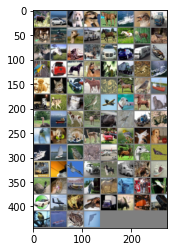

deer  car   dog   dog   horse ship  bird  truck cat   horse bird  truck horse horse deer  deer  deer  horse truck deer  car   car   truck ship  bird  car   horse horse deer  truck bird  ship  dog   cat   car   horse cat   horse bird  ship  truck dog   cat   bird  plane dog   horse cat   bird  ship  dog   deer  dog   bird  truck frog  bird  dog   dog   deer  car   bird  cat   dog   ship  ship  bird  frog  plane horse bird  plane car   cat   plane car   dog   truck frog  ship  bird  dog   ship  horse horse deer  truck frog  car   plane frog  cat   truck deer  truck truck bird  ship  frog  plane


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
#Train
loss_arr = []
for i in range(num_epoch):
    for j,[image,label] in enumerate(trainloader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())